The goal of this experiment is to clip the weight fields to 95 percentile to observe if we get better performance if the outliers are brought to scale close to 99 percent of the data,

## Imports

In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [2]:
import warnings
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

import mlflow

from src.utils import r2_and_adjusted_r2_score as score, root_mean_squared_error as rmse
from src.mlflow_util import setup_mlflow_experiment as setup_exp

warnings.filterwarnings('ignore')


## Read Data

In [3]:
raw_data_dir = os.path.join(parent_dir, 'data', 'raw')

In [4]:
df = pd.read_csv(os.path.join(raw_data_dir, 'insurance.csv'))

In [5]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


## MLFlow Setup

In [26]:
exp_name = 'Premium Prediction - stratified by Age - Weight clipped'
exp_description = '''The goal is to predict the PremiumPrice based on the given features.
Data is splitted using the Age feature to ensure that the distribution of Age is similar in both train and test sets.
There are no engineered features in this experiment. 

The weight fields as it had some outlier, is clipped to 95 percentile to observe if the model performs better with outliers
'''

experiment = setup_exp(exp_name, exp_description)

experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='file:///Users/wasimmujawar/Projects/Insurance-Price-Predictor/mlruns/759679825484628345', creation_time=1737152164806, experiment_id='759679825484628345', last_update_time=1737154163955, lifecycle_stage='active', name='Premium Prediction - stratified by Age - Weight clipped', tags={'mlflow.note.content': 'The goal is to predict the PremiumPrice based on the '
                        'given features.\n'
                        'Data is splitted using the Age feature to ensure that '
                        'the distribution of Age is similar in both train and '
                        'test sets.\n'
                        'There are no engineered features in this '
                        'experiment.\n'}>

## Model Building

### Clipping weight

In [7]:
column_name = 'Weight'
percentile = 0.95

percentile_value = df[column_name].quantile(percentile)

df[column_name] = np.where(df[column_name] > percentile_value,
                                   percentile_value,
                                   df[column_name])

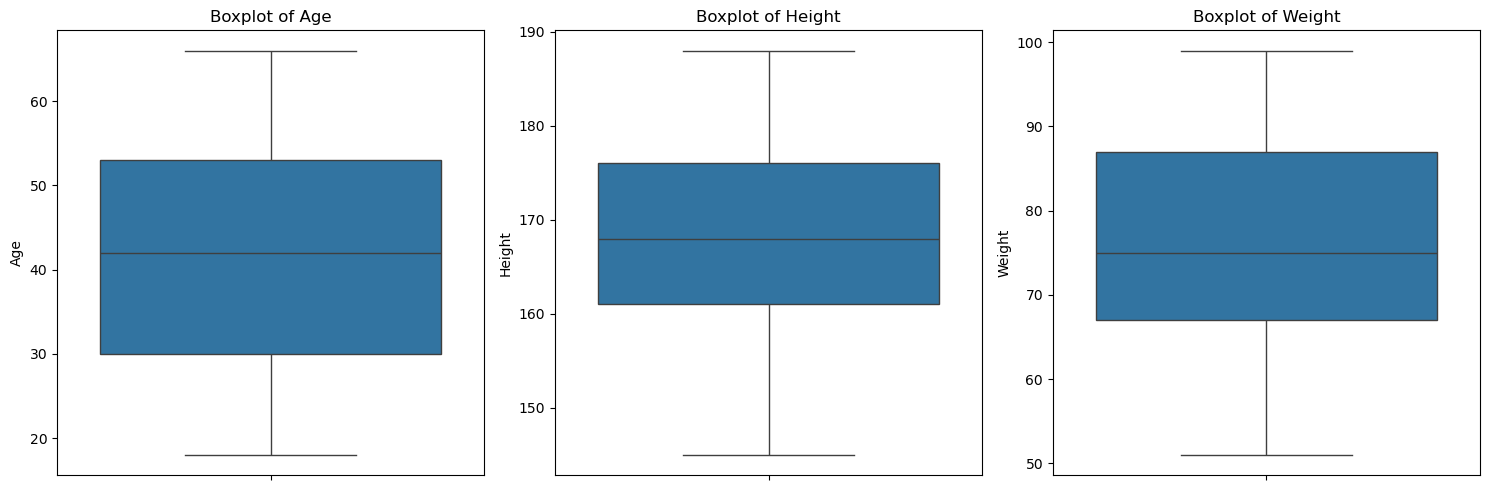

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['Age', 'Height', 'Weight']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax = ax.flatten()

for index, column in enumerate(numeric_columns):
    sns.boxplot(y=df[column], ax=ax[index])
    ax[index].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

### Train Test Split

In [9]:
age_bins = [18, 25, 40, 55, np.inf]
age_labels = ['Young Adult', 'Adult', 
              'Middle Aged Adults', 'Senior']

age_category = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

In [10]:
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57.0,0,0,0,25000
1,60,1,0,0,0,180,73.0,0,0,0,29000
2,36,1,1,0,0,158,59.0,0,0,1,23000
3,52,1,1,0,1,183,93.0,0,0,2,28000
4,38,0,0,0,1,166,88.0,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67.0,0,0,0,15000
982,64,1,1,0,0,153,70.0,0,0,3,28000
983,56,0,1,0,0,155,71.0,0,0,1,29000
984,47,1,1,0,0,158,73.0,1,0,1,39000


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['PremiumPrice']), df['PremiumPrice'],
                                                    stratify=age_category, test_size=0.2, random_state=42)

### Linear Regression

In [12]:
numeric_columns = ['Age', 'Height', 'Weight']
binary_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_columns),
    ('passthrough', 'passthrough', binary_columns)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

with mlflow.start_run(run_name="Linear Regression"):
    pipeline.fit(X_train, y_train)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    rmse_train = rmse(y_train, y_train_pred)
    rmse_test = rmse(y_test, y_test_pred)
    
    signature = mlflow.models.infer_signature(X_train, y_train_pred)

    r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
    r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])
    
    mlflow.set_tag('Model', 'Linear Regression')
    mlflow.log_metric('Train - RMSE', rmse_train)
    mlflow.log_metric('Test - RMSE', rmse_test)
    mlflow.log_metric('Train - r2 score', r2_train)
    mlflow.log_metric('Test - r2 score', r2_test)
    mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
    mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
    
    mlflow.sklearn.log_model(pipeline, 'model',  signature=signature)
    

### Decision Tree

In [13]:
def run_mlflow_decision_tree(max_dept: int) -> None:
    with mlflow.start_run(run_name="Decision Tree"):
        model = DecisionTreeRegressor(max_depth=max_dept)
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        rmse_train = rmse(y_train, y_train_pred)
        rmse_test = rmse(y_test, y_test_pred)
        
        signature = mlflow.models.infer_signature(X_train, y_train_pred)


        r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
        r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])
        
        mlflow.set_tag('Model', 'Decision Tree Regressor')
        
        mlflow.log_param('max_depth', max_dept)
        mlflow.log_metric('Train - RMSE', rmse_train)
        mlflow.log_metric('Test - RMSE', rmse_test)
        mlflow.log_metric('Train - r2 score', r2_train)
        mlflow.log_metric('Test - r2 score', r2_test)
        mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
        mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)

        mlflow.sklearn.log_model(model, 'model',  signature=signature)

In [14]:
for depth in range(3, 9):
    run_mlflow_decision_tree(depth)

### Random Forest Regressor

In [15]:
def run_mlflow_random_forest(n_estimators: int, max_dept: int, max_feature: str = None) -> None:
    with mlflow.start_run(run_name="Random Forest"):
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                        max_depth=max_dept, 
                                        max_features=max_feature, 
                                        n_jobs=-1)
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        rmse_train = rmse(y_train, y_train_pred)
        rmse_test = rmse(y_test, y_test_pred)
        
        signature = mlflow.models.infer_signature(X_train, y_train_pred)

        r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
        r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])
        
        mlflow.set_tag('Model', 'Random Forest Regressor')
        mlflow.log_param('n_estimators', n_estimators)
        mlflow.log_param('max_depth', max_dept)
        mlflow.log_param('max_features', max_feature)
        mlflow.log_metric('Train - RMSE', rmse_train)
        mlflow.log_metric('Test - RMSE', rmse_test)
        mlflow.log_metric('Train - r2 score', r2_train)
        mlflow.log_metric('Test - r2 score', r2_test)
        mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
        mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
        mlflow.sklearn.log_model(model, 'model',  signature=signature)

In [16]:
n_estimator = [80, 90, 100]
max_depth = [3, 4, 5, 6, 7, 8]
max_features = [None, 'sqrt', 'log2']

for n_est in n_estimator:
    for depth in max_depth:
        for feature in max_features:
            run_mlflow_random_forest(n_est, depth, feature)

In [17]:
run_mlflow_random_forest(90, 7)

In [18]:
run_mlflow_random_forest(100, 7)

### Gradient Boosting Regressor

In [19]:
def run_mlflow_gbdt(loss: str, learning_rate: float, n_estimators: int, max_dept: int) -> None:
    with mlflow.start_run(run_name="GBDT"):
        model = GradientBoostingRegressor(n_estimators=n_estimators, 
                                            max_depth=max_dept, 
                                            learning_rate=learning_rate, 
                                            loss=loss)
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        rmse_train = rmse(y_train, y_train_pred)
        rmse_test = rmse(y_test, y_test_pred)
        
        signature = mlflow.models.infer_signature(X_train, y_train_pred)

        r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
        r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])
        
        mlflow.set_tag('Model', 'GBDT Regressor')
        mlflow.log_param('loss', loss)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('n_estimators', n_estimators)
        mlflow.log_param('max_depth', max_dept)
        mlflow.log_metric('Train - RMSE', rmse_train)
        mlflow.log_metric('Test - RMSE', rmse_test)
        mlflow.log_metric('Train - r2 score', r2_train)
        mlflow.log_metric('Test - r2 score', r2_test)
        mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
        mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
        mlflow.sklearn.log_model(model, 'model',  signature=signature)

In [20]:
loss = ['squared_error', 'huber']
n_estimator = [80, 90, 100, 110, 120]
max_depth = [3, 4, 5, 6]
learning_rate = [0.01, 0.1, 0.2, 0.3]

In [21]:
for l in loss:
    for n_est in n_estimator:
        for depth in max_depth:
            for lr in learning_rate:
                run_mlflow_gbdt(l, lr, n_est, depth)

### XGBoost Regression

In [22]:
def run_mlflow_xgboost(max_dept: int, n_estimators: int, learning_rate: float, reg_alpha: float, reg_lambda: float) -> None:
    with mlflow.start_run(run_name="XGBoost"):
        model = xgb.XGBRegressor(max_depth=max_dept, n_estimators=n_estimators, 
                                 learning_rate=learning_rate, n_jobs=-1, reg_alpha=reg_alpha, 
                                 reg_lambda=reg_lambda)
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        rmse_train = rmse(y_train, y_train_pred)
        rmse_test = rmse(y_test, y_test_pred)
        
        signature = mlflow.models.infer_signature(X_train, y_train_pred)

        r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
        r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])
        
        mlflow.set_tag('Model', 'XGBoost Regressor')
        mlflow.log_param('max_depth', max_dept)
        mlflow.log_param('n_estimators', n_estimators)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('reg_alpha', reg_alpha)
        mlflow.log_param('reg_lambda', reg_lambda)
        mlflow.log_metric('Train - RMSE', rmse_train)
        mlflow.log_metric('Test - RMSE', rmse_test)
        mlflow.log_metric('Train - r2 score', r2_train)
        mlflow.log_metric('Test - r2 score', r2_test)
        mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
        mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
        mlflow.sklearn.log_model(model, 'model',  signature=signature)

In [23]:
n_estimator = [80, 90, 95, 100]
reg_alpha = [0.1, 0.3, 0.5, 0.7]
reg_lambda = [0.1, 0.3, 0.5, 0.7]
max_depth = [5, 6, 7]
learning_rate = [0.02, 0.03, 0.04]

for n_est in n_estimator:
    for depth in max_depth:
        for lr in learning_rate:
            for alpha in reg_alpha:
                for lam in reg_lambda:
                    run_mlflow_xgboost(depth, n_est, lr, alpha, lam)

### Stacking Regression

In [24]:
base_learner = [
    ('gb1', GradientBoostingRegressor(n_estimators=110, max_depth=5, learning_rate=0.1, loss='huber')),
    ('gb2', GradientBoostingRegressor(n_estimators=120, max_depth=5, learning_rate=0.1, loss='huber')),
    ('rd1', RandomForestRegressor(n_estimators=100, max_depth=7, n_jobs=-1)),
    ('rd2', RandomForestRegressor(n_estimators=90, max_depth=7, n_jobs=-1)),
    ('xg1', xgb.XGBRegressor(max_depth=6, n_estimators=90, learning_rate=0.03, reg_alpha=0.5, reg_lambda=0.7)),
    ('xg2', xgb.XGBRegressor(max_depth=6, n_estimators=80, learning_rate=0.04, reg_alpha=0.1, reg_lambda=0.7))
]

final_estimator = LinearRegression()

with mlflow.start_run(run_name="Stacking Regressor"):
    model = StackingRegressor(estimators=base_learner, final_estimator=final_estimator)
    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = rmse(y_train, y_train_pred)
    rmse_test = rmse(y_test, y_test_pred)

    signature = mlflow.models.infer_signature(X_train, y_train_pred)

    r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
    r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])

    mlflow.set_tag('Model', 'Stacking Regressor')
    mlflow.log_metric('Train - RMSE', rmse_train)
    mlflow.log_metric('Test - RMSE', rmse_test)
    mlflow.log_metric('Train - r2 score', r2_train)
    mlflow.log_metric('Test - r2 score', r2_test)
    mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
    mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
    mlflow.sklearn.log_model(model, 'model',  signature=signature)

### Voting Regressor

In [25]:
with mlflow.start_run(run_name='Voting Regressor'):
    model = VotingRegressor(estimators=base_learner)
    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = rmse(y_train, y_train_pred)
    rmse_test = rmse(y_test, y_test_pred)

    signature = mlflow.models.infer_signature(X_train, y_train_pred)

    r2_train, adj_r2_train = score(y_train, y_train_pred, X_train.shape[0], X_train.shape[1])
    r2_test, adj_r2_test = score(y_test, y_test_pred, X_test.shape[0], X_test.shape[1])

    mlflow.set_tag('Model', 'Voting Regressor')
    mlflow.log_metric('Train - RMSE', rmse_train)
    mlflow.log_metric('Test - RMSE', rmse_test)
    mlflow.log_metric('Train - r2 score', r2_train)
    mlflow.log_metric('Test - r2 score', r2_test)
    mlflow.log_metric('Train - Adjusted r2 score', adj_r2_train)
    mlflow.log_metric('Test - Adjusted r2 score', adj_r2_test)
    mlflow.sklearn.log_model(model, 'model',  signature=signature)

## Observations

Clipping the weights to the 95th percentile did not result in any noticeable improvement in performance. This indicates that limiting the weight values to reduce the influence of extreme outliers had no significant impact on the model's predictive ability or overall performance metrics.